## Problem 2

In [4]:
import functools
from IPython.display import display

import jax
import jax.numpy as jnp
import numpy as np
np.seterr(invalid="ignore")

import matplotlib.pyplot as plt; plt.rcParams.update({'font.size': 20})
import matplotlib.collections
import matplotlib.transforms
from ipywidgets import interact, interactive

from typing import Callable, NamedTuple

In [5]:

class LinearDynamics(NamedTuple):
    f_x: jnp.array  # A
    f_u: jnp.array  # B

    def __call__(self, x, u, k=None):
        f_x, f_u = self
        return f_x @ x + f_u @ u if k is None else self[k](x, u)

    def __getitem__(self, key):
        return jax.tree_map(lambda x: x[key], self)


class AffinePolicy(NamedTuple):
    l: jnp.array  # l
    l_x: jnp.array  # L

    def __call__(self, x, k=None):
        l, l_x = self
        return l + l_x @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_map(lambda x: x[key], self)


class QuadraticCost(NamedTuple):
    c: jnp.array  # c
    c_x: jnp.array  # q
    c_u: jnp.array  # r
    c_xx: jnp.array  # Q
    c_uu: jnp.array  # R
    c_ux: jnp.array  # H.T

    @classmethod
    def from_pure_quadratic(cls, c_xx, c_uu, c_ux):
        return cls(
            jnp.zeros((c_xx.shape[:-2])),
            jnp.zeros(c_xx.shape[:-1]),
            jnp.zeros(c_uu.shape[:-1]),
            c_xx,
            c_uu,
            c_ux,
        )

    def __call__(self, x, u, k=None):
        c, c_x, c_u, c_xx, c_uu, c_ux = self
        return c + c_x @ x + c_u @ u + x @ c_xx @ x / 2 + u @ c_uu @ u / 2 + u @ c_ux @ x if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_map(lambda x: x[key], self)


class QuadraticStateCost(NamedTuple):
    v: jnp.array  # p (scalar)
    v_x: jnp.array  # p (vector)
    v_xx: jnp.array  # P

    @classmethod
    def from_pure_quadratic(cls, v_xx):
        return cls(
            jnp.zeros(v_xx.shape[:-2]),
            jnp.zeros(v_xx.shape[:-1]),
            v_xx,
        )

    def __call__(self, x, k=None):
        v, v_x, v_xx = self
        return v + v_x @ x + x @ v_xx @ x / 2 if k is None else self[k](x)

    def __getitem__(self, key):
        return jax.tree_map(lambda x: x[key], self)


def rollout_state_feedback_policy(dynamics, policy, x0, step_range, x_nom=None, u_nom=None):
    def scan_fn(x, k):
        u = policy(x, k) if x_nom is None else u_nom[k] + policy(x - x_nom[k], k)
        x1 = dynamics(x, u, k)
        return (x1, (x1, u))

    xs, us = jax.lax.scan(scan_fn, x0, step_range)[1]
    return jnp.concatenate([x0[None], xs]), us


def riccati_step(
    current_step_dynamics: LinearDynamics,
    current_step_cost: QuadraticCost,
    next_state_value: QuadraticStateCost,
):
    f_x, f_u = current_step_dynamics
    c, c_x, c_u, c_xx, c_uu, c_ux = current_step_cost
    v, v_x, v_xx = next_state_value

    q = c + v
    q_x = c_x + f_x.T @ v_x
    q_u = c_u + f_u.T @ v_x
    q_xx = c_xx + f_x.T @ v_xx @ f_x
    q_uu = c_uu + f_u.T @ v_xx @ f_u
    q_ux = c_ux + f_u.T @ v_xx @ f_x

    l = -jnp.linalg.solve(q_uu, q_u)
    l_x = -jnp.linalg.solve(q_uu, q_ux)

    current_state_value = QuadraticStateCost(
        q - l.T @ q_uu @ l / 2,
        q_x - l_x.T @ q_uu @ l,
        q_xx - l_x.T @ q_uu @ l_x,
    )
    current_step_optimal_policy = AffinePolicy(l, l_x)
    return current_state_value, current_step_optimal_policy


def ensure_positive_definite(a, eps=1e-3):
    w, v = jnp.linalg.eigh(a)
    return (v * jnp.maximum(w, eps)) @ v.T


class TotalCost(NamedTuple):
    running_cost: Callable
    terminal_cost: Callable

    def __call__(self, xs, us):
        step_range = jnp.arange(us.shape[0])
        return jnp.sum(jax.vmap(self.running_cost)(xs[:-1], us, step_range)) + self.terminal_cost(xs[-1])


class EulerIntegrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using the Euler method."""
    ode: Callable
    dt: float

    @jax.jit
    def __call__(self, x, u, k):
        return x + self.dt * self.ode(x, u)


class RK4Integrator(NamedTuple):
    """Discrete time dynamics from time-invariant continuous time dynamics using a 4th order Runge-Kutta method."""
    ode: Callable
    dt: float

    @jax.jit
    def __call__(self, x, u, k):
        k1 = self.dt * self.ode(x, u)
        k2 = self.dt * self.ode(x + k1 / 2, u)
        k3 = self.dt * self.ode(x + k2 / 2, u)
        k4 = self.dt * self.ode(x + k3, u)
        return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    #@jax.jit
    #def __call__(self, x, u, k):
    #    A = np.array([[4.315e-11, 0],
    #                  [0, 4.315e-11]])
    #    B = np.array([[1, 0],
    #                  [0, 1]])
    #    return A@x + B@u


@jax.jit
# Run every single MPC loop (Every time we plan over the horizon)
def iterative_linear_quadratic_regulator(dynamics, total_cost, x0, u_guess, maxiter=100, atol=1e-3):
    running_cost, terminal_cost = total_cost
    n, (N, m) = x0.shape[-1], u_guess.shape  # Initial state and control inputs
    step_range = jnp.arange(N) # 0, 1, 2, 3,..., N - 1

    xs, us = rollout_state_feedback_policy(dynamics, lambda x, k: u_guess[k], x0, step_range)
    j = total_cost(xs, us)

    def continuation_criterion(loop_vars):
        i, _, _, j_curr, j_prev = loop_vars
        return (j_curr < j_prev - atol) & (i < maxiter)

    def ilqr_iteration(loop_vars):
        i, xs, us, j_curr, j_prev = loop_vars

        f_x, f_u = jax.vmap(jax.jacobian(dynamics, (0, 1)))(xs[:-1], us, step_range)
        c = jax.vmap(running_cost)(xs[:-1], us, step_range)
        c_x, c_u = jax.vmap(jax.grad(running_cost, (0, 1)))(xs[:-1], us, step_range)
        (c_xx, c_xu), (c_ux, c_uu) = jax.vmap(jax.hessian(running_cost, (0, 1)))(xs[:-1], us, step_range)
        v, v_x, v_xx = terminal_cost(xs[-1]), jax.grad(terminal_cost)(xs[-1]), jax.hessian(terminal_cost)(xs[-1])

        # Ensure quadratic cost terms are positive definite.
        c_zz = jnp.block([[c_xx, c_xu], [c_ux, c_uu]])
        c_zz = jax.vmap(ensure_positive_definite)(c_zz)
        c_xx, c_uu, c_ux = c_zz[:, :n, :n], c_zz[:, -m:, -m:], c_zz[:, -m:, :n]
        v_xx = ensure_positive_definite(v_xx)

        linearized_dynamics = LinearDynamics(f_x, f_u)
        quadratized_running_cost = QuadraticCost(c, c_x, c_u, c_xx, c_uu, c_ux)
        quadratized_terminal_cost = QuadraticStateCost(v, v_x, v_xx)

        def scan_fn(next_state_value, current_step_dynamics_cost):
            current_step_dynamics, current_step_cost = current_step_dynamics_cost
            current_state_value, current_step_policy = riccati_step(
                current_step_dynamics,
                current_step_cost,
                next_state_value,
            )
            return current_state_value, current_step_policy

        policy = jax.lax.scan(scan_fn,
                              quadratized_terminal_cost, (linearized_dynamics, quadratized_running_cost),
                              reverse=True)[1]

        def rollout_linesearch_policy(alpha):
            # Note that we roll out the true `dynamics`, not the `linearized_dynamics`!
            l, l_x = policy
            return rollout_state_feedback_policy(dynamics, AffinePolicy(alpha * l, l_x), x0, step_range, xs, us)

        # Backtracking line search (step sizes evaluated in parallel).
        all_xs, all_us = jax.vmap(rollout_linesearch_policy)(0.5**jnp.arange(16))
        js = jax.vmap(total_cost)(all_xs, all_us)
        a = jnp.argmin(js)
        j = js[a]
        xs = jnp.where(j < j_curr, all_xs[a], xs)
        us = jnp.where(j < j_curr, all_us[a], us)
        return i + 1, xs, us, jnp.minimum(j, j_curr), j_curr

    i, xs, us, j, _ = jax.lax.while_loop(continuation_criterion, ilqr_iteration, (0, xs, us, j, jnp.inf))

    return {
        "optimal_trajectory": (xs, us),
        "optimal_cost": j,
        "num_iterations": i,
    }


class ContinuousTimeBeadDynamics(NamedTuple):
    def __call__(self, state, control):
        """
        Full Dynamics: mẍ + ẋβ + k(x - u) = η(t) + F(t)
        x : postion of bead
        u : postion of trap

        m = 0 : (negligible bead mass)
        β : damping coefficient (~10e-8)
        k : spring constant (~10e-5)
        η(t) = 0 : thermal forces on bead (negligible)
        F(t) = 0 : external forces on bead (negligible)

        Simplified dynamics: ẋβ + k(x - u) = 0

        Solve for ẋ: ẋ = k(-x + u) / β
        """

        x, y = state  # x and y positions of the bead
        u_x, u_y = control  # x and y positions of the trap
        b = 10e-8  # 10e-8
        k = 10e-5  # 10e-5
        return jnp.array([
            (-k * x + k * u_x) / b,
            (-k * y + k * u_y) / b
        ])


""" Environment Setup """
class Asteroid(NamedTuple):
    center: jnp.array
    radius: jnp.array
    velocity: jnp.array

    def at_time(self, time):
        return self._replace(center=self.center + self.velocity * time)


class Environment(NamedTuple):
    asteroids: Asteroid
    obj_bead_radius: float
    bubble_radius: float
    bounds: jnp.array

    @classmethod
    def create(cls, num_asteroids, obj_bead_radius=1.0, bubble_radius=3.0, bounds=(50, 40)):
        bounds = np.array(bounds)
        return cls(
            Asteroid(
                np.random.rand(num_asteroids, 2) * bounds,
                np.ones(num_asteroids),
                10*np.random.randn(num_asteroids, 2),
            ), obj_bead_radius, bubble_radius, bounds)

    def at_time(self, time):
        return self._replace(asteroids=self.asteroids.at_time(time))

    def wrap_vector(self, vector):
        return (vector + self.bounds / 2) % self.bounds - self.bounds / 2
    

    def plot(self, state=None, plan=None, history=None, ax=None):
        if state is None:
            state = np.full(2, np.nan)
        plan = np.full((0, 2), np.nan) if plan is None else plan[:, :2]
        history = np.full((0, 2), np.nan) if history is None else history[:, :2]

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.set_xlim(0, self.bounds[0])
            ax.set_ylim(0, self.bounds[1])
            ax.set_aspect(1)
            asteroids = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Circle(np.zeros(2), r) for r in self.asteroids.radius] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    color="black",
                ))
            obj_bead = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Circle(np.zeros(2), self.obj_bead_radius)] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    color="red",
                    zorder=10,
                ))
            circle = ax.add_collection(
                matplotlib.collections.PatchCollection(
                    [plt.Circle(np.zeros(2), self.bubble_radius)] * 4,
                    offsets=np.zeros(2),
                    transOffset=matplotlib.transforms.AffineDeltaTransform(ax.transData),
                    facecolor=(0, 0, 0, 0),
                    edgecolor="black",
                    linestyle="--",
                    zorder=10,
                ))
            plan_line = ax.plot(plan[:, 0], plan[:, 1], color="green")[0]
            history_line = ax.plot(history[:, 0], history[:, 1], color="blue")[0]
        else:
            fig = ax.figure
            asteroids, obj_bead, circle = ax.collections
            plan_line, history_line = ax.lines
        screen_offsets = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        asteroids.set_offsets(
            (self.wrap_vector(self.asteroids.center) + self.bounds * screen_offsets[:, None, :]).reshape(-1, 2))

        obj_bead.set_offsets((self.wrap_vector(state[:2]) + self.bounds * screen_offsets))
        circle.set_offsets((self.wrap_vector(state[:2]) + self.bounds * screen_offsets))

        def tile_line(line):
            if line.shape[0] == 0:
                return line
            irange, jrange = [
                range(int(x[0]), int(x[1] + 1))
                for x in zip(np.min(line, 0) // self.bounds,
                             np.max(line, 0) // self.bounds)
            ]
            return np.concatenate([
                np.pad(line - np.array([i, j]) * self.bounds, ((0, 1), (0, 0)), constant_values=np.nan)
                for i in irange
                for j in jrange
            ], 0)

        plan_line.set_data(*tile_line(plan).T)
        history_line.set_data(*tile_line(history).T)
        return fig, ax


""" Running and Total Cost """
class RunningCost(NamedTuple):
    env: Environment
    dt: jnp.array

    def __call__(self, state, control, step):
        # NOTE: many parameters (gains, offsets) in this function could be lifted to fields of `RunningCost`, in which
        # case you could experiment with changing these parameters without incurring `jax.jit` recompilation.
        asteroids = self.env.asteroids.at_time(step * self.dt)

        separation_distance = jnp.where(
            jnp.isnan(asteroids.radius), np.inf,
            jnp.linalg.norm(self.env.wrap_vector(state[:2] - asteroids.center), axis=-1) - asteroids.radius -
            self.env.obj_bead_radius)
        collision_avoidance_penalty = jnp.sum(
            jnp.where(separation_distance > 0.3, 0, 1e4 * (0.3 - separation_distance)**2))

        u_x, u_y = control

        # u_x_penalty = jnp.where(u_x < 0, 1e8, 1e2*u_x)
        # u_y_penalty = jnp.where(u_y < 0, 1e8, 1e2*u_y)

        # u_x_max_penalty = jnp.where(u_x > 120, 1e8, 0)
        # u_y_max_penalty = jnp.where(u_y > 120, 1e8, 0)
        x_dist = 1e2*(state[0] - u_x)**2
        y_dist = 1e2*(state[1] - u_y)**2

        #jax.debug.print("Dist = {dist}",dist=dist)

        control_penalty = jnp.where(x_dist > 8, 1e8, 0) + jnp.where(y_dist > 8, 1e8, 0)

        return collision_avoidance_penalty + x_dist + y_dist # + u_x_penalty + u_y_penalty 


class FullHorizonTerminalCost(NamedTuple):
    env: Environment
    goal_position: jnp.array

    @classmethod
    def create_ignoring_extra_args(cls, env, goal_position, *args, **kwargs):
        return cls(env, goal_position)

    def __call__(self, state):
        return 1000 * (jnp.sum(jnp.square(state[:2] - self.goal_position)) + state[3]**2)

# Generate an initial guess for the control sequence
def gen_intial_traj(start_state, goal_state, N):
    xs, ys = start_state
    xg, yg = goal_state

    x_traj = np.linspace(xs, xg, N)
    y_traj = np.linspace(ys, yg, N)

    traj = np.array([x_traj.T, y_traj.T])

    return traj

start_state = np.array([5., 6.])
goal_position = np.array([13., 15.])

u_guess = gen_intial_traj(start_state, goal_position, 20).T
""" MPC """
@functools.partial(jax.jit, static_argnames=["running_cost_type", "terminal_cost_type", "limited_sensing", "N"])
def policy(state, env, dynamics, running_cost_type, terminal_cost_type, limited_sensing=False, N=20):
    #if limited_sensing:
    #    env = env.sense(state[:2])
    empty_env = Environment.create(0)
    solution = iterative_linear_quadratic_regulator(
        dynamics,
        TotalCost(
            running_cost_type(empty_env, dynamics.dt),
            terminal_cost_type.create_ignoring_extra_args(
                empty_env,
                goal_position,
                state[:2],
                empty_env.bubble_radius,
            ),
        ),
        state,
        u_guess,
    )
    solution = iterative_linear_quadratic_regulator(
        dynamics,
        TotalCost(
            running_cost_type(env, dynamics.dt),
            terminal_cost_type.create_ignoring_extra_args(
                env,
                goal_position,
                state[:2],
                env.bubble_radius,
            ),
        ),
        state,
        solution["optimal_trajectory"][1],
    )
    states, controls = solution["optimal_trajectory"]
    return controls[0], (states, controls)


def simulate_mpc(start_state, env, dynamics, running_cost_type, terminal_cost_type, limited_sensing=False, N=20, T=1250):
    states = [start_state]
    controls = []
    plans = []
    for t in range(T):
        control, (mpc_states, mpc_controls) = policy(states[-1], env.at_time(t * dynamics.dt), dynamics,
                                                     running_cost_type, terminal_cost_type, limited_sensing, N)
        states.append(mpc_states[1])
        controls.append(control)
        plans.append(mpc_states)
        #print(mpc_states)
    states = np.array(states)
    controls = np.array(controls)
    plans = np.array(plans)

    return states, controls



C:\Users\Jordan\AppData\Local\Temp\ipykernel_11728\3145250804.py:22: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[key], self)
C:\Users\Jordan\AppData\Local\Temp\ipykernel_11728\3145250804.py:22: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda x: x[key], self)


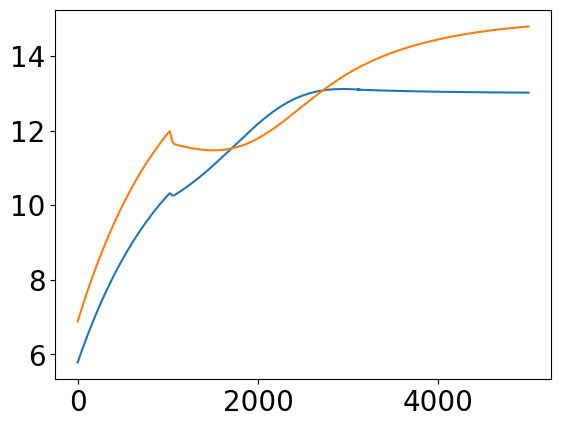

interactive(children=(IntSlider(value=0, description='k', max=5000), Output()), _dom_classes=('widget-interact…

In [6]:
# Problem parameters.
T = 5000
dt = 1e-5

dynamics = RK4Integrator(ContinuousTimeBeadDynamics(), dt)

np.random.seed(2)
env = Environment.create(20)


states, controls = simulate_mpc(start_state, env, dynamics, RunningCost, FullHorizonTerminalCost, False, 20, T)

# print(states)
# print(controls)

plt.plot(np.arange(0, len(controls)), controls)
plt.plot(np.arange(0, len(states)), states)
plt.show()


fig, ax = env.plot()
plt.close()


@interact(k=(0, T))
def plot(k=0):
    env.at_time(k * dt).plot(states[k], states[:k + 1], states[k:], ax=ax)
    return fig